In [1]:
# Libraries
import pandas as pd
import numpy as np
import os #required to list file names in folder to load them into dataframes
import glob

# Required for Public holidays
from datetime import date
import holidays # pip install holidays [https://pypi.org/project/holidays/]

# Required to normalise the values for logistic regression
from sklearn import preprocessing

# Required for visualisation
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

# Required for Logistic Regression
from sklearn.linear_model import LogisticRegression


# Required for Investigations to Improve Accuracy
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score


C:\Users\ellio\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# If you would like to 'Run All code' then please enter the desired dales prediction date.
# Please use the format YYYY-MM-DD
prediction_dt = '2017-04-01'

In [72]:
# Create a single dataframe that contains all SKUs, Pirce and Units from the individual source files. The DF will be 
# twice the size, given Price will be populated in the top hald and Units in the bottom half.
files = glob.glob("./data/sku_price/*.csv") + glob.glob("./data/sku_unitssold/*.csv")
combined = pd.DataFrame()
for file in files:
    df = pd.read_csv(file, sep = ';')
    df['ident'] = file
    ## new here
    df['ga:productSku'] = df['ga:productSku'].astype(str)
    ## new here end    
    combined = combined.append(df, ignore_index = True, sort=True)
    #combined.append(df, ignore_index = True, sort=True)

In [73]:
# A new 'Date' column will be added to the DF. This value is derived from the filename/ path of the source file.
combined['Date'] = (combined.ident.replace(to_replace =r'^.\W\w+\W\w+\W', value = '', regex = True)
                        .str.strip('.csv'))

In [74]:
# Columns renamed into something easier to work with. Note that the SKU is a string (Object) and not an integer - therefore
# will be named 'SKUstr'
combined.rename(columns={'ga:productSku': 'SKU', 'ga:revenuePerItem': 'UnitPrice','ga:uniquePurchases': 'Units'}, inplace=True)

In [76]:
# Working DF with each SKU only appearing once is made using Groupby
df = combined.groupby(['Date','SKU'])['Units','UnitPrice'].sum()
df.reset_index(inplace=True)
df.head()

C:\Users\ellio\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,Date,SKU,Units,UnitPrice
0,2017-03-01,3108547,1.0,102.67
1,2017-03-01,3108850,1.0,415.78
2,2017-03-01,3109793,1.0,214.80
3,2017-03-01,3109978,1.0,156.00
4,2017-03-01,3114551,1.0,25.33


In [80]:
df['ExtPrice'] = df['Units'] * df['UnitPrice']

In [81]:
df_trans = df.copy()

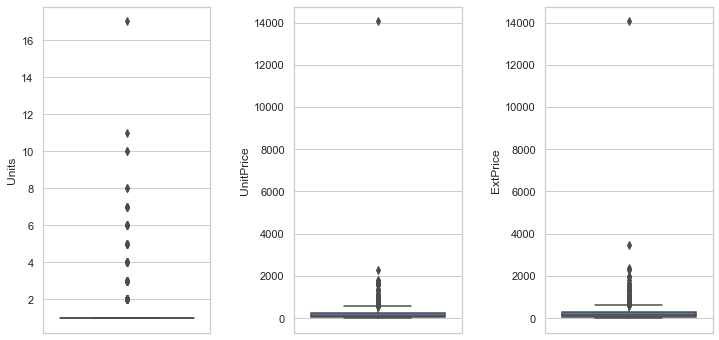

In [82]:
# As part of data cleaning, it is usually important look for outliers in the data, which has been done before.
# Note: Given the relatively small dataset AND requirement to predict a probability for EACH SKU, I did not feel that there 
# was an option but to keep all data. Happy to discuss this in person.

fig, ax = plt.subplots(1,3, figsize=(12, 6))
sns.boxplot(y=df_trans['Units'], ax=ax[0])
sns.boxplot(y=df_trans['UnitPrice'], ax=ax[1])
sns.boxplot(y=df_trans['ExtPrice'], ax=ax[2])
plt.subplots_adjust(wspace=0.5)

In [231]:
# Part 1 - Getting data required to calculate  AWP i.e. Sum of Units and Sum of Extended Revenue

df_awp = df_trans.groupby(['SKU'])[['Units','ExtPrice']].agg('sum').reset_index()
df_awp.columns = ['SKU','TotalUnits','TotalRev']

# Part 2 - Calculating AWP
df_awp['AWP'] = df_awp.TotalRev  / df_awp.TotalUnits

# Part 3 - Creating a pseudo inventory master file with all relevant data that can be 
# used for feature engineering (AWP, max units, max price)
df_inv_mast = df_awp.copy()

print("df_awp info:")
display(df_awp.shape)
display(df_awp.head())

print("df_inv_mast info:")
display(df_inv_mast.shape)
display(df_inv_mast.dtypes)
display(df_inv_mast.isna().sum())
display(df_inv_mast.head())

df_awp info:


(1245, 4)

,SKU,TotalUnits,TotalRev,AWP
0,310027,2.0,742.14,371.07
1,310052,1.0,7.81,7.81
2,3104223,1.0,91.35,91.35
3,3104418,1.0,23.97,23.97
4,3104470,1.0,287.61,287.61


df_inv_mast info:


(1245, 4)

SKU            object
TotalUnits    float64
TotalRev      float64
AWP           float64
dtype: object

SKU           0
TotalUnits    0
TotalRev      0
AWP           0
dtype: int64

,SKU,TotalUnits,TotalRev,AWP
0,310027,2.0,742.14,371.07
1,310052,1.0,7.81,7.81
2,3104223,1.0,91.35,91.35
3,3104418,1.0,23.97,23.97
4,3104470,1.0,287.61,287.61


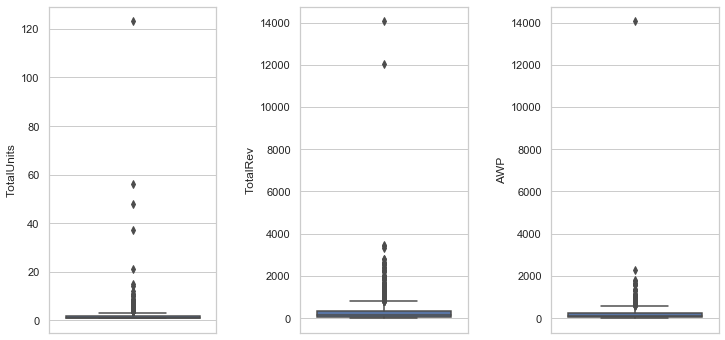

In [232]:
# As above, checking for outliers in df_inv_mast.
fig, ax = plt.subplots(1,3, figsize=(12, 6))
sns.boxplot(y=df_inv_mast['TotalUnits'], ax=ax[0])
sns.boxplot(y=df_inv_mast['TotalRev'], ax=ax[1])
sns.boxplot(y=df_inv_mast['AWP'], ax=ax[2])
plt.subplots_adjust(wspace=0.5)

In [233]:
## NEW SECTION KNN on INVMAST to CATEGORISE THEM - WHICH WILL HELP WITH OUTLIER REMOVAL

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [254]:
df_inv_mast.head()

,SKU,TotalUnits,TotalRev,AWP
0,310027,2.0,742.14,371.07
1,310052,1.0,7.81,7.81
2,3104223,1.0,91.35,91.35
3,3104418,1.0,23.97,23.97
4,3104470,1.0,287.61,287.61


In [255]:
df_im_clust = df_inv_mast.copy()
df_im_clust.set_index('SKU', inplace=True)
df_im_clust.head()

,TotalUnits,TotalRev,AWP
SKU,,,
310027,2.0,742.14,371.07
310052,1.0,7.81,7.81
3104223,1.0,91.35,91.35
3104418,1.0,23.97,23.97
3104470,1.0,287.61,287.61


In [256]:
kmeans = KMeans(n_clusters=1000)
stock_clusters = kmeans.fit(df_im_clust)
#october_clusters.cluster_centers_

In [257]:
df_im_clust['label'] = stock_clusters.fit_predict(df_im_clust)
df_im_clust.head()

,TotalUnits,TotalRev,AWP,label
SKU,,,,
310027,2.0,742.14,371.07,423
310052,1.0,7.81,7.81,770
3104223,1.0,91.35,91.35,745
3104418,1.0,23.97,23.97,441
3104470,1.0,287.61,287.61,632


In [263]:
#Normalize the new 'priceUSD' column for analysis
# Create variable x and pass in the float verion of column 'priceUSD'
x = df_im_clust[['label']].values.astype(float)

# Create a minimum and maximum processor object
min_max_scaler = preprocessing.MinMaxScaler()

# Create an object to transform the data to fit minmax processor
x_scaled = min_max_scaler.fit_transform(x)

# Append the normalised values within a new column in the dataframe.
#df_im_clust['labelNORM'] = pd.DataFrame(x_scaled)
df_im_clust['labelNORM'] = min_max_scaler.fit_transform(x)

In [267]:
df_im_clust.reset_index(inplace=True)

In [268]:
df_im_clust.head()

,SKU,TotalUnits,TotalRev,AWP,label,labelNORM
0,310027,2.0,742.14,371.07,423,0.423423
1,310052,1.0,7.81,7.81,770,0.770771
2,3104223,1.0,91.35,91.35,745,0.745746
3,3104418,1.0,23.97,23.97,441,0.441441
4,3104470,1.0,287.61,287.61,632,0.632633


In [269]:
df_inv_mast2 = df_im_clust.copy()

In [109]:
# A new DF is created (df_working) as it will ultimately be used for the training of the logistic regression model.
df_working = df_trans.copy()

# Need to add the target to these existing transactions.
df_working['isSold'] = 1

# Check that everything looks OK.
df_working.head()

,Date,SKU,Units,UnitPrice,ExtPrice,isSold
0,2017-03-01,3108547,1.0,102.67,102.67,1
1,2017-03-01,3108850,1.0,415.78,415.78,1
2,2017-03-01,3109793,1.0,214.80,214.80,1
3,2017-03-01,3109978,1.0,156.00,156.00,1
4,2017-03-01,3114551,1.0,25.33,25.33,1


In [104]:
# test only
df_working['isSold'].value_counts()

1    1886
Name: isSold, dtype: int64

In [113]:
lst_is_sold0 = []
for date in df_trans['Date'].unique(): #Date    
    for SKU in df_trans['SKU'].unique(): #SKU
        new_row = {
            "Date": date,
            "SKU": SKU,
            "Units": 0,
            "UnitPrice": 0,
            "ExtPrice": 0,
            "isSold": 0
                }
        lst_is_sold0.append(new_row)

In [114]:
pd.DataFrame(lst_is_sold0)

,Date,SKU,Units,UnitPrice,ExtPrice,isSold
0,2017-03-01,3108547,0,0,0,0
1,2017-03-01,3108850,0,0,0,0
2,2017-03-01,3109793,0,0,0,0
3,2017-03-01,3109978,0,0,0,0
4,2017-03-01,3114551,0,0,0,0
...,...,...,...,...,...,...
38590,2017-03-31,374634,0,0,0,0
38591,2017-03-31,378974,0,0,0,0
38592,2017-03-31,396541,0,0,0,0
38593,2017-03-31,396875,0,0,0,0


In [127]:
# Creating the new columns 'isSold' = 1
# This is significantly faster than the original!

print("The shape of the df_working DF BEFORE is: {}".format(df_working.shape))

# For each day that we have transactions, we need to create a new row of data that contains the SKU and DATE.
lst_is_sold0 = []
for date in df_trans['Date'].unique(): #Date    
    for SKU in df_trans['SKU'].unique(): #SKU
        new_row = {
            "Date": date,
            "SKU": SKU,
            "Units": 0,
            "UnitPrice": 0,
            "ExtPrice": 0,
            "isSold": 0
                }
        lst_is_sold0.append(new_row)

df_iSold0 = pd.DataFrame(lst_is_sold1)        

# The process above has just created 31 * 1245 = 38.595 new rows. 
# The duplicates need to be deleted - leaving the original transactions
df_working = df_working.append(df_iSold0, ignore_index=True, sort=False)
df_working = df_working.drop_duplicates(subset=['SKU','Date'], keep='first')
print("The shape of the df_working DF AFTER is: {}".format(df_working.shape))

The shape of the df_working DF BEFORE is: (38595, 6)
The shape of the df_working DF AFTER is: (38595, 6)


In [128]:
# Checking to make sure that the true transaction count has not gone down. (Should be 1886)
# Note: This also tells us that there is going to be an unbalance of the target class for the logistic regression model.
display(df_working.isSold.value_counts())
display(df_working.head(2))
display(df_working.tail(2))

# There should be 31 transactions per SKU and 1245 transactions for every day of them month.
display(df_working.groupby('SKU').agg({'Date': ['count']}))
display(df_working.groupby('Date').agg({'SKU': ['count']}))

0    36709
1     1886
Name: isSold, dtype: int64

,Date,SKU,Units,UnitPrice,ExtPrice,isSold
0,2017-03-01,3108547,1.0,102.67,102.67,1
1,2017-03-01,3108850,1.0,415.78,415.78,1


,Date,SKU,Units,UnitPrice,ExtPrice,isSold
38593,2017-03-31,397311,0.0,0.0,NaN,0
38594,2017-03-31,397434,0.0,0.0,NaN,0


,Date
,count
SKU,
310027,31
310052,31
3104223,31
3104418,31
3104470,31
...,...
399822,31
399853,31


,SKU
,count
Date,
2017-03-01,1245
2017-03-02,1245
2017-03-03,1245
2017-03-04,1245
2017-03-05,1245
2017-03-06,1245
2017-03-07,1245
2017-03-08,1245


In [129]:
print("Inventory Master Info before:")
display(df_inv_mast.head())
display(df_inv_mast.shape)

Inventory Master Info before:


,SKU,TotalUnits,TotalRev,AWP
0,310027,2.0,742.14,371.07
1,310052,1.0,7.81,7.81
2,3104223,1.0,91.35,91.35
3,3104418,1.0,23.97,23.97
4,3104470,1.0,287.61,287.61


(1245, 4)

In [270]:
## Joining df_inv_mast to get relevant data for all rows of transactions DF.
#df_working2 = pd.merge(left=df_working, right=df_inv_mast, how='left', left_on='SKU', right_on='SKU')
#df_working2 = df_working.merge(df_inv_mast, how='left', left_on='SKU', right_on='SKU')
df_working2 = df_working.merge(df_inv_mast2, how='left', left_on='SKU', right_on='SKU')

In [271]:
print("Resulting dataframe with transaction and product info:")
display(df_working2.shape)
display(df_working2.info())
display(df_working2.head(1))
display(df_working2.tail(1))

Resulting dataframe with transaction and product info:


(38595, 11)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38595 entries, 0 to 38594
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        38595 non-null  object 
 1   SKU         38595 non-null  object 
 2   Units       38595 non-null  float64
 3   UnitPrice   38595 non-null  float64
 4   ExtPrice    1886 non-null   float64
 5   isSold      38595 non-null  int64  
 6   TotalUnits  38595 non-null  float64
 7   TotalRev    38595 non-null  float64
 8   AWP         38595 non-null  float64
 9   label       38595 non-null  int32  
 10  labelNORM   38595 non-null  float64
dtypes: float64(7), int32(1), int64(1), object(2)
memory usage: 3.4+ MB


None

,Date,SKU,Units,UnitPrice,ExtPrice,isSold,TotalUnits,TotalRev,AWP,label,labelNORM
0,2017-03-01,3108547,1.0,102.67,102.67,1,2.0,205.34,102.67,431,0.431431


,Date,SKU,Units,UnitPrice,ExtPrice,isSold,TotalUnits,TotalRev,AWP,label,labelNORM
38594,2017-03-31,397434,0.0,0.0,NaN,0,1.0,73.55,73.55,261,0.261261


In [272]:
df_working2['ExtPrice'] = df_working2['ExtPrice'].fillna(0)

In [273]:
# Creating a backup of working dataframe - just in case!
df_working_bup = df_working2.copy()

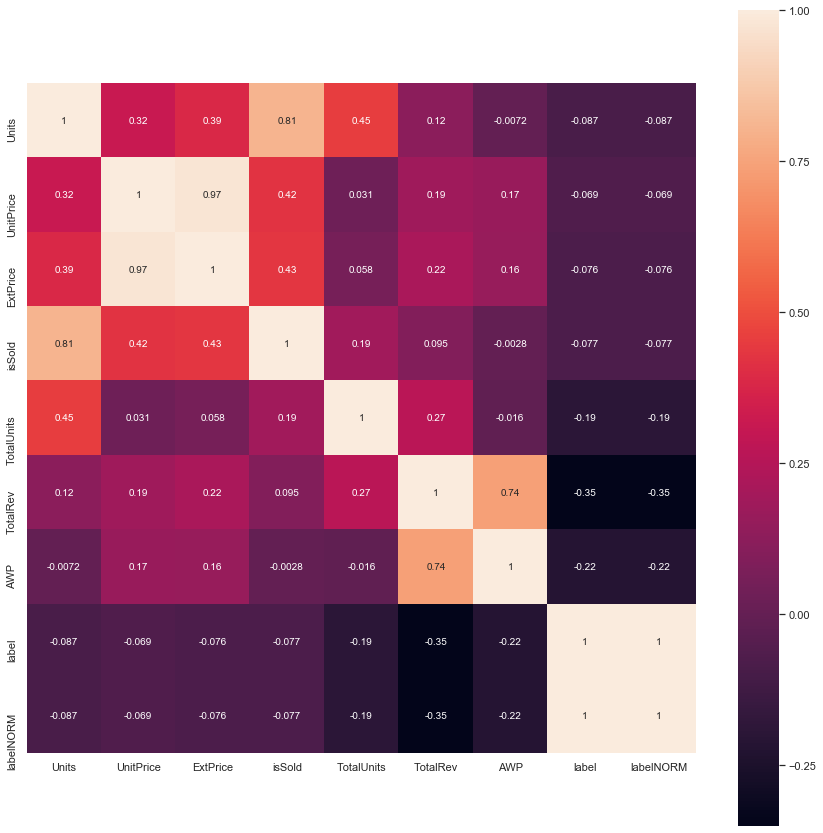

In [274]:
# Displaying a Correlation Matrix to see how things are looking with the data
plt.figure(figsize=(15, 15))
p = sns.heatmap(df_working2.corr(), annot=True, square=True)

#### Dates and Feature Engineering

Now that we have a complete set of data (that will rely on date for the prediction), it's a good idea to convert the existing 'Date' field (currently a string) into DateTime and to get some other useful information such as:
- Day of week by name (Monday - Sunday);
- Day of week by number;
- Day of month number (1-31);
- Week of year number;
- Is the day a weekend (1/0); and 
- Is the day a public holiday in Spain (0/1).

Finally get dummy variables will be sought for the Day of the Week.

In [275]:
# Identify Public Holiday
def public_holiday(row): 
    """
    Input: Date as string
    Output: 1 or 0 if the specific date is a public holiday or not.
    
    The purpose of this function is to determine if the date is a public holiday in Spain (ES)
    # This requires 'holidays' to be installed, as show in in the libraries at the start of this file.
    """
    try:
        es_holidays = holidays.CountryHoliday('ES', years=[2017])
        return(row.date_dt in es_holidays)
    except:
        return False

In [276]:
# Extracting features from string date
df_working2['date_dt']= pd.to_datetime(df_working2['Date']) #String to datetime
df_working2['date_DoW'] = df_working2['date_dt'].dt.day_name() #Day of week i.e. Monday, Tuesday
df_working2['date_DoWnum'] = df_working2['date_dt'].dt.dayofweek #Day of week number
df_working2['date_DoM'] = df_working2['date_dt'].dt.day # Day of month number
# No value in week of year given it's all the same
#df_working2['date_WoY'] = df_working2['date_dt'].dt.week # Week number of year
df_working2['isWeekend_date'] = np.where(df_working2['date_DoW'].isin(['Sunday','Saturday']),1,0) # was isWeekend
df_working2['isPublicHol_date'] = df_working2.apply(public_holiday, axis=1).astype(int) # isPublicHol

# Get Dummies for Day of Week
dummy = pd.get_dummies(df_working2['date_DoW'])

df_working3 = df_working2.merge(dummy, left_index=True , right_index=True)

# Turn column names into is... i.e. isMonday
dict_days = {}
for i in df_working3['date_DoW'].unique():
    dict_days[i] = 'is' + i  


# Raname columns
df_working3.rename(columns=dict_days, inplace=True)
df_working3.head()



# Binning Day of Month
bins = [0, 10, 20, 31]
labels = ['month_start','month_middle','month_end']
df_working3['time_of_month'] = pd.cut(df_working3['date_DoM'], bins=bins, labels=labels)

# Get Dummies for Day of Week
dummy = pd.get_dummies(df_working3['time_of_month'])

df_working3 = df_working3.merge(dummy, left_index=True , right_index=True)

# Turn column names into is... i.e. isMonday
dict_days = {}
for i in df_working3['time_of_month'].unique():
    dict_days[i] = 'is' + i  


# Raname columns
df_working3.rename(columns=dict_days, inplace=True)
df_working3.head()

,Date,SKU,Units,UnitPrice,ExtPrice,isSold,TotalUnits,TotalRev,AWP,label,...,isMonday,isSaturday,isSunday,isThursday,isTuesday,isWednesday,time_of_month,ismonth_start,ismonth_middle,ismonth_end
0,2017-03-01,3108547,1.0,102.67,102.67,1,2.0,205.34,102.670,431,...,0,0,0,0,0,1,month_start,1,0,0
1,2017-03-01,3108850,1.0,415.78,415.78,1,8.0,3326.24,415.780,49,...,0,0,0,0,0,1,month_start,1,0,0
2,2017-03-01,3109793,1.0,214.80,214.80,1,12.0,2586.42,215.535,150,...,0,0,0,0,0,1,month_start,1,0,0
3,2017-03-01,3109978,1.0,156.00,156.00,1,7.0,1092.00,156.000,100,...,0,0,0,0,0,1,month_start,1,0,0
4,2017-03-01,3114551,1.0,25.33,25.33,1,1.0,25.33,25.330,626,...,0,0,0,0,0,1,month_start,1,0,0


In [277]:
df_working3.columns

Index(['Date', 'SKU', 'Units', 'UnitPrice', 'ExtPrice', 'isSold', 'TotalUnits',
       'TotalRev', 'AWP', 'label', 'labelNORM', 'date_dt', 'date_DoW',
       'date_DoWnum', 'date_DoM', 'isWeekend_date', 'isPublicHol_date',
       'isFriday', 'isMonday', 'isSaturday', 'isSunday', 'isThursday',
       'isTuesday', 'isWednesday', 'time_of_month', 'ismonth_start',
       'ismonth_middle', 'ismonth_end'],
      dtype='object')

In [298]:
df_fs = df_working3.copy()

In [299]:
df_fs.set_index(['SKU', 'date_dt'], inplace=True)

In [300]:
df_fs

,,Date,Units,UnitPrice,ExtPrice,isSold,TotalUnits,TotalRev,AWP,label,labelNORM,...,isMonday,isSaturday,isSunday,isThursday,isTuesday,isWednesday,time_of_month,ismonth_start,ismonth_middle,ismonth_end
SKU,date_dt,,,,,,,,,,,,,,,,,,,,,
3108547,2017-03-01,2017-03-01,1.0,102.67,102.67,1,2.0,205.34,102.670,431,0.431431,...,0,0,0,0,0,1,month_start,1,0,0
3108850,2017-03-01,2017-03-01,1.0,415.78,415.78,1,8.0,3326.24,415.780,49,0.049049,...,0,0,0,0,0,1,month_start,1,0,0
3109793,2017-03-01,2017-03-01,1.0,214.80,214.80,1,12.0,2586.42,215.535,150,0.150150,...,0,0,0,0,0,1,month_start,1,0,0
3109978,2017-03-01,2017-03-01,1.0,156.00,156.00,1,7.0,1092.00,156.000,100,0.100100,...,0,0,0,0,0,1,month_start,1,0,0
3114551,2017-03-01,2017-03-01,1.0,25.33,25.33,1,1.0,25.33,25.330,626,0.626627,...,0,0,0,0,0,1,month_start,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
380017,2017-03-31,2017-03-31,0.0,0.00,0.00,0,1.0,73.20,73.200,648,0.648649,...,0,0,0,0,0,0,month_end,0,0,1
384437,2017-03-31,2017-03-31,0.0,0.00,0.00,0,1.0,48.76,48.760,198,0.198198,...,0,0,0,0,0,0,month_end,0,0,1
396842,2017-03-31,2017-03-31,0.0,0.00,0.00,0,1.0,23.97,23.970,441,0.441441,...,0,0,0,0,0,0,month_end,0,0,1


In [301]:
#df_fs.drop(['Date', 'date_DoW', 'ExtPrice', 'date_WoY', 'date_DoWnum', 'date_DoM','time_of_month'], axis=1, inplace=True)
df_fs.drop(['Date', 'date_DoW', 'ExtPrice', 'date_DoWnum', 'date_DoM','time_of_month','TotalUnits', 'TotalRev', 'AWP'], axis=1, inplace=True)

In [302]:
cols = list(df_fs.columns)
cols.remove('isSold')
cols

['Units',
 'UnitPrice',
 'label',
 'labelNORM',
 'isWeekend_date',
 'isPublicHol_date',
 'isFriday',
 'isMonday',
 'isSaturday',
 'isSunday',
 'isThursday',
 'isTuesday',
 'isWednesday',
 'ismonth_start',
 'ismonth_middle',
 'ismonth_end']

In [303]:
#df_fs = df_fs[cols][df_fs['isSold'] == 1]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000240741DA160>]],
      dtype=object)

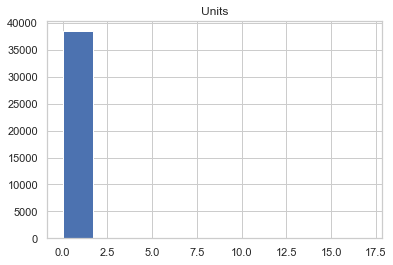

In [304]:
df_fs[['Units']].hist()

In [305]:
df_fs.columns

Index(['Units', 'UnitPrice', 'isSold', 'label', 'labelNORM', 'isWeekend_date',
       'isPublicHol_date', 'isFriday', 'isMonday', 'isSaturday', 'isSunday',
       'isThursday', 'isTuesday', 'isWednesday', 'ismonth_start',
       'ismonth_middle', 'ismonth_end'],
      dtype='object')

In [306]:
df_fs_l = df_fs.copy()
df_fs_l.drop(['labelNORM'], axis=1, inplace=True)

df_fs_ln = df_fs.copy()
df_fs_ln.drop(['label'], axis=1, inplace=True)

In [ ]:
### Tring just Label (regular)

In [307]:
df_fs_l.head()

,,Units,UnitPrice,isSold,label,isWeekend_date,isPublicHol_date,isFriday,isMonday,isSaturday,isSunday,isThursday,isTuesday,isWednesday,ismonth_start,ismonth_middle,ismonth_end
SKU,date_dt,,,,,,,,,,,,,,,,
3108547,2017-03-01,1.0,102.67,1,431,0,0,0,0,0,0,0,0,1,1,0,0
3108850,2017-03-01,1.0,415.78,1,49,0,0,0,0,0,0,0,0,1,1,0,0
3109793,2017-03-01,1.0,214.80,1,150,0,0,0,0,0,0,0,0,1,1,0,0
3109978,2017-03-01,1.0,156.00,1,100,0,0,0,0,0,0,0,0,1,1,0,0
3114551,2017-03-01,1.0,25.33,1,626,0,0,0,0,0,0,0,0,1,1,0,0


In [ ]:
#from sklearn.datasets import make_friedman1
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
X = df_fs_l.drop('isSold', axis=1)
y = df_fs_l[['isSold']]
estimator = SVR(kernel="linear")
selector = RFE(estimator, n_features_to_select=5, step=1)
selector = selector.fit(X, y)
selector.support_
selector.ranking_


C:\Users\ellio\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
df_fs_l[['isSold']].ravel()